<a href="https://colab.research.google.com/github/AdarshKhatri01/Video-Surveillance/blob/train/Hockey_Pytorch_Splitted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/drive/MyDrive/Violence-Detection/archive.zip -d /content/drive/MyDrive/Violence-Detection/dataset

Archive:  /content/drive/MyDrive/Violence-Detection/archive.zip
  inflating: /content/drive/MyDrive/Violence-Detection/dataset/data/fi100_xvid.avi  
  inflating: /content/drive/MyDrive/Violence-Detection/dataset/data/fi101_xvid.avi  
  inflating: /content/drive/MyDrive/Violence-Detection/dataset/data/fi102_xvid.avi  
  inflating: /content/drive/MyDrive/Violence-Detection/dataset/data/fi103_xvid.avi  
  inflating: /content/drive/MyDrive/Violence-Detection/dataset/data/fi104_xvid.avi  
  inflating: /content/drive/MyDrive/Violence-Detection/dataset/data/fi105_xvid.avi  
  inflating: /content/drive/MyDrive/Violence-Detection/dataset/data/fi106_xvid.avi  
  inflating: /content/drive/MyDrive/Violence-Detection/dataset/data/fi107_xvid.avi  
  inflating: /content/drive/MyDrive/Violence-Detection/dataset/data/fi108_xvid.avi  
  inflating: /content/drive/MyDrive/Violence-Detection/dataset/data/fi109_xvid.avi  
  inflating: /content/drive/MyDrive/Violence-Detection/dataset/data/fi10_xvid.avi  
  

# **IMPORTING REQUIRED LIBRARIES**

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Constants
FRAMES = 10
EPOCHS = 30
PATIENCE = 5
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

# Path to your dataset
DATA_PATH = '/content/drive/MyDrive/Violence-Detection/dataset/data'

In [ ]:
# Code to check the files in dataset

# !ls -R /content/drive/MyDrive/Violence-Detection/dataset/data

In [ ]:
# data_path = '/content/drive/MyDrive/Violence-Detection/dataset/data'
# dataset = VideoDataset(root_dir=data_path, transform=transform)
# print(f"Total Videos Found: {len(dataset)}")


Found video: /content/drive/MyDrive/Violence-Detection/dataset/data/fi100_xvid.avi (Label: 1)
Found video: /content/drive/MyDrive/Violence-Detection/dataset/data/fi101_xvid.avi (Label: 1)
Found video: /content/drive/MyDrive/Violence-Detection/dataset/data/fi102_xvid.avi (Label: 1)
Found video: /content/drive/MyDrive/Violence-Detection/dataset/data/fi103_xvid.avi (Label: 1)
Found video: /content/drive/MyDrive/Violence-Detection/dataset/data/fi104_xvid.avi (Label: 1)
Found video: /content/drive/MyDrive/Violence-Detection/dataset/data/fi105_xvid.avi (Label: 1)
Found video: /content/drive/MyDrive/Violence-Detection/dataset/data/fi106_xvid.avi (Label: 1)
Found video: /content/drive/MyDrive/Violence-Detection/dataset/data/fi107_xvid.avi (Label: 1)
Found video: /content/drive/MyDrive/Violence-Detection/dataset/data/fi108_xvid.avi (Label: 1)
Found video: /content/drive/MyDrive/Violence-Detection/dataset/data/fi109_xvid.avi (Label: 1)
Found video: /content/drive/MyDrive/Violence-Detection/datas

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, sequence_length=FRAMES, transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.sequence_length = sequence_length
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def extract_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_interval = max(1, total_frames // self.sequence_length)

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if len(frames) < self.sequence_length:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (224, 224))
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)
            else:
                break
        cap.release()

        # Pad with last frame if needed
        while len(frames) < self.sequence_length:
            frames.append(frames[-1])

        return torch.stack(frames)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = self.extract_frames(video_path)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return frames, label

In [ ]:
# Transformation for video frames
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
# Load all video files and labels
video_paths = []
labels = []
for file in os.listdir(DATA_PATH):
    file_path = os.path.join(DATA_PATH, file)
    if os.path.isfile(file_path) and file.endswith(".avi"):
        label = 1 if file.startswith("fi") else 0
        video_paths.append(file_path)
        labels.append(label)

# Split dataset (70% train, 15% validation, 15% test)
train_idx, temp_idx = train_test_split(range(len(video_paths)), test_size=0.3, stratify=labels, random_state=42)
valid_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx], random_state=42)

# Create dataset subsets
train_dataset = VideoDataset([video_paths[i] for i in train_idx], [labels[i] for i in train_idx], transform=transform)
valid_dataset = VideoDataset([video_paths[i] for i in valid_idx], [labels[i] for i in valid_idx], transform=transform)
test_dataset = VideoDataset([video_paths[i] for i in test_idx], [labels[i] for i in test_idx], transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train size: {len(train_dataset)}, Valid size: {len(valid_dataset)}, Test size: {len(test_dataset)}")


Train size: 700, Valid size: 150, Test size: 150


In [ ]:
# Define Model
class ViolenceDetectionModel(nn.Module):
    def __init__(self):
        super(ViolenceDetectionModel, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.lstm = nn.LSTM(input_size=2048, hidden_size=128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.shape
        x = x.view(batch_size * seq_len, c, h, w)

        with torch.no_grad():
            x = self.feature_extractor(x)

        x = x.view(batch_size, seq_len, -1)
        lstm_out, _ = self.lstm(x)
        output = self.sigmoid(self.fc(lstm_out[:, -1, :]))
        return output


In [ ]:
# Initialize model and check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Using GPU: {gpu_name}")
else:
    print("Using CPU")

# Define model, loss function, and optimizer
model = ViolenceDetectionModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = np.inf  # Initialize with a large value
    patience_counter = 0  # Tracks epochs without improvement

    for epoch in range(num_epochs):
        total_train_loss = 0

        # ✅ Ensure model is in training mode
        model.train()

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for frames, labels in progress_bar:
            frames, labels = frames.to(device), labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(frames)
            loss = criterion(outputs, labels)
            loss.backward()  # 🔥 Backpropagation (must be in training mode)
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 🔥 Validate the model after every epoch
        model.eval()  # ✅ Switch to evaluation mode

        correct = 0
        total = 0
        total_val_loss = 0

        with torch.no_grad():
            for frames, labels in val_loader:
                frames, labels = frames.to(device), labels.to(device).unsqueeze(1)
                outputs = model(frames)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        accuracy = (correct / total) * 100

        val_losses.append(avg_val_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

        # 🛑 Early Stopping Logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  # Reset counter
            model_save_path = "/content/drive/MyDrive/Violence-Detection/models/violence_detection_splitted_model.pth"
            torch.save(model.state_dict(), model_save_path)
            # torch.save(model.state_dict(), "best_model.pth")  # Save best model
            print("✅ Model improved. Saving new best model.")
        else:
            patience_counter += 1
            print(f"⏳ No improvement for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print("🛑 Early stopping triggered. Training stopped.")
            break  # Stop training

    return train_losses, val_losses, val_accuracies


train_losses, val_losses, val_accuracies = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=EPOCHS, patience=PATIENCE)


Using GPU: Tesla T4


Epoch 1/30 - Train Loss: 0.5877, Val Loss: 0.3787, Val Accuracy: 94.67%
✅ Model improved. Saving new best model.


Epoch 2/30 - Train Loss: 0.3402, Val Loss: 0.1773, Val Accuracy: 95.33%
✅ Model improved. Saving new best model.


Epoch 3/30 - Train Loss: 0.2586, Val Loss: 0.1417, Val Accuracy: 95.33%
✅ Model improved. Saving new best model.


Epoch 4/30 - Train Loss: 0.2163, Val Loss: 0.2062, Val Accuracy: 93.33%
⏳ No improvement for 1 epoch(s).


Epoch 5/30 - Train Loss: 0.2299, Val Loss: 0.1203, Val Accuracy: 96.67%
✅ Model improved. Saving new best model.


Epoch 6/30 - Train Loss: 0.2111, Val Loss: 0.0961, Val Accuracy: 98.00%
✅ Model improved. Saving new best model.


Epoch 7/30 - Train Loss: 0.1732, Val Loss: 0.1135, Val Accuracy: 97.33%
⏳ No improvement for 1 epoch(s).


Epoch 8/30 - Train Loss: 0.1796, Val Loss: 0.1058, Val Accuracy: 98.00%
⏳ No improvement for 2 epoch(s).


Epoch 9/30 - Train Loss: 0.1550, Val Loss: 0.0713, Val Accuracy: 98.67%
✅ Model improved. Saving new best model.


Epoch 10/30 - Train Loss: 0.1757, Val Loss: 0.0911, Val Accuracy: 97.33%
⏳ No improvement for 1 epoch(s).


Epoch 11/30 - Train Loss: 0.1358, Val Loss: 0.0676, Val Accuracy: 98.00%
✅ Model improved. Saving new best model.


Epoch 12/30 - Train Loss: 0.1504, Val Loss: 0.0682, Val Accuracy: 98.00%
⏳ No improvement for 1 epoch(s).


Epoch 13/30 - Train Loss: 0.1124, Val Loss: 0.0711, Val Accuracy: 98.67%
⏳ No improvement for 2 epoch(s).


Epoch 14/30 - Train Loss: 0.1844, Val Loss: 0.2861, Val Accuracy: 88.00%
⏳ No improvement for 3 epoch(s).


Epoch 15/30 - Train Loss: 0.1335, Val Loss: 0.0663, Val Accuracy: 98.67%
✅ Model improved. Saving new best model.


Epoch 16/30 - Train Loss: 0.0870, Val Loss: 0.0557, Val Accuracy: 98.67%
✅ Model improved. Saving new best model.


Epoch 17/30 - Train Loss: 0.0764, Val Loss: 0.0936, Val Accuracy: 98.00%
⏳ No improvement for 1 epoch(s).


Epoch 18/30 - Train Loss: 0.1552, Val Loss: 0.1874, Val Accuracy: 92.00%
⏳ No improvement for 2 epoch(s).


Epoch 19/30 - Train Loss: 0.1209, Val Loss: 0.0634, Val Accuracy: 98.00%
⏳ No improvement for 3 epoch(s).


Epoch 20/30 - Train Loss: 0.0924, Val Loss: 0.1441, Val Accuracy: 95.33%
⏳ No improvement for 4 epoch(s).


Epoch 21/30 - Train Loss: 0.0890, Val Loss: 0.0742, Val Accuracy: 98.00%
⏳ No improvement for 5 epoch(s).
🛑 Early stopping triggered. Training stopped.


# **SAVING THE MODEL**

In [ ]:
# Save Model
# model_save_path = "/content/drive/MyDrive/Violence-Detection/models/violence_detection_splitted_model.pth"
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to: {model_save_path}")


Model saved to: /content/drive/MyDrive/Violence-Detection/models/violence_detection_splitted_model.pth


---
---
---
# **EVALUATION ON TEST DATASET**
---
---
---

In [ ]:
# Evaluate Model on Test Data
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for frames, labels in data_loader:
            frames, labels = frames.to(device), labels.to(device).unsqueeze(1)
            outputs = model(frames)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_model(model, test_loader)

Test Accuracy: 96.00%


# **Load the Model**

In [ ]:
# model = ViolenceDetectionModel().to(device)
# model.load_state_dict(torch.load('/content/drive/MyDrive/Violence-Detection/models/violence_detection_splitted_model.pth'))
# model.eval()
# print("Model loaded successfully.")

Model loaded successfully.


---
---
---

# **EVALUATION ON SINGLE VIDEO**

---
---
---

# **Load and Preprocess the Video**

In [ ]:
def preprocess_video(video_path, sequence_length=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224, 224))
        frame = transform(frame)
        frames.append(frame)

    cap.release()

    # Pad if necessary
    while len(frames) < sequence_length:
        frames.append(frames[-1])

    frames = torch.stack(frames[:sequence_length])
    return frames.unsqueeze(0)  # Add batch dimension


In [ ]:
# video_path = os.path.join(DATA_PATH, "/content/drive/MyDrive/Violence-Detection/dataset/data/fi100_xvid.avi")
video_path = os.path.join(DATA_PATH, "no100_xvid.avi")
frames = preprocess_video(video_path).to(device)

model.eval()
with torch.no_grad():
    output = model(frames)
    prediction = "Fight" if output.item() > 0.5 else "No Fight"
    print(f"Prediction: {prediction}")


Prediction: No Fight


---
---
---
# **PLOTTING**
---
---
---

ValueError: x and y must have same first dimension, but have shapes (21,) and (1,)

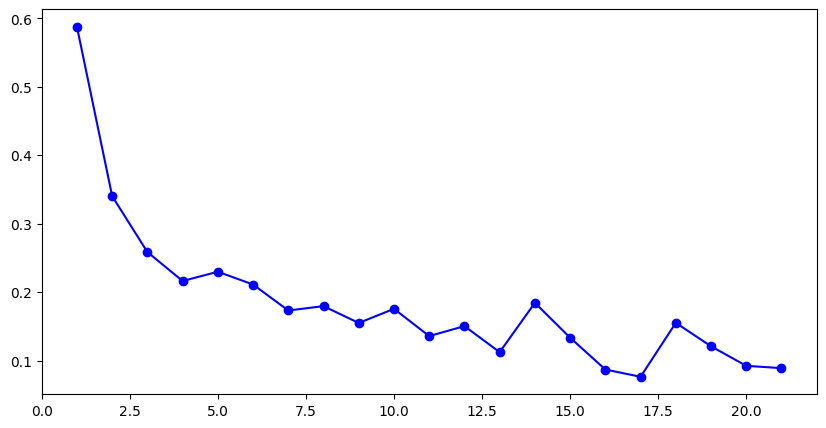

In [ ]:
# Misatkenly run another cell which orverwrites val_losses making it single valued array that's why plotting giving error

epochs = range(1, len(train_losses) + 1)

# Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train Loss", marker="o", color='blue')
plt.plot(epochs, val_losses, label="Validation Loss", marker="o", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()
plt.show()
